In [ ]:
'''Scenario-1 : Earth Observation'''

In [ ]:
''' Question 1: Spatial Reasoning & Data Filtering'''

In [1]:
!pip install pyproj

In [2]:
import os, re, json, math
from pathlib import Path
from pyproj import Transformer
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path as MplPath
import pandas as pd

# Parsing GeoJSON 
def extract_polygons_from_geojson(path):
    with open(path, "r") as f:
        data = json.load(f)

    polys = []
    for feat in data["features"]:
        geom = feat["geometry"]
        t = geom["type"].lower()

        if t == "polygon":
            exterior = geom["coordinates"][0]
            polys.append([(float(x), float(y)) for x, y in exterior])

        elif t == "multipolygon":
            for poly in geom["coordinates"]:
                exterior = poly[0]
                polys.append([(float(x), float(y)) for x, y in exterior])

    return polys


# Building UTM grid
def build_grid_from_polygons(polygons, cell_size_m=60000, utm_epsg=32644):

    all_lons = [pt[0] for poly in polygons for pt in poly]
    all_lats = [pt[1] for poly in polygons for pt in poly]

    min_lon, max_lon = min(all_lons), max(all_lons)
    min_lat, max_lat = min(all_lats), max(all_lats)

    to_utm = Transformer.from_crs(4326, utm_epsg, always_xy=True)
    to_wgs = Transformer.from_crs(utm_epsg, 4326, always_xy=True)

    minx, miny = to_utm.transform(min_lon, min_lat)
    maxx, maxy = to_utm.transform(max_lon, max_lat)

    minx = math.floor(minx / cell_size_m) * cell_size_m
    miny = math.floor(miny / cell_size_m) * cell_size_m
    maxx = math.ceil(maxx / cell_size_m) * cell_size_m
    maxy = math.ceil(maxy / cell_size_m) * cell_size_m

    grid_cells = []
    centers = []

    x = minx
    while x < maxx:
        y = miny
        while y < maxy:

            bl = to_wgs.transform(x, y)
            br = to_wgs.transform(x + cell_size_m, y)
            tr = to_wgs.transform(x + cell_size_m, y + cell_size_m)
            tl = to_wgs.transform(x, y + cell_size_m)

            grid_cells.append([bl, br, tr, tl, bl])

            cx = x + cell_size_m/2
            cy = y + cell_size_m/2
            centers.append(to_wgs.transform(cx, cy))

            y += cell_size_m
        x += cell_size_m

    return grid_cells, centers


# Matplotlib Path containment
def build_paths(polygons):
    return [MplPath(np.array(poly)) for poly in polygons]


def point_in_any_polygon(lon, lat, paths):
    return any(p.contains_point((lon, lat)) for p in paths)


# Parse "lat_lon.png"
def parse_latlon_from_filename(fn):
    base = os.path.basename(fn)
    m = re.match(r"(?P<lat>-?\d+\.\d+)[_,-](?P<lon>-?\d+\.\d+)", base)
    return float(m.group("lat")), float(m.group("lon"))



# Main
def main(root_dir):
    root = Path(root_dir)
    geojson_path = root / "delhi_ncr_region.geojson"
    rgb_dir = root / "rgb"
    out_dir = root / "outputs"
    out_dir.mkdir(exist_ok=True)

    print("Loading GeoJSON…")
    polygons = extract_polygons_from_geojson(geojson_path)
    print("Polygons:", len(polygons))

    paths = build_paths(polygons)

    print("Building grid…")
    grid_cells_wgs, centers_wgs = build_grid_from_polygons(polygons)
    print("Grid cells:", len(grid_cells_wgs))

    # Plot
    fig, ax = plt.subplots(figsize=(10,10))
    for poly in polygons:
        arr = np.array(poly)
        ax.plot(arr[:,0], arr[:,1], color="black")
    for cell in grid_cells_wgs:
        arr = np.array(cell)
        ax.plot(arr[:,0], arr[:,1], color="red", linewidth=0.3)
    centers_arr = np.array(centers_wgs)
    ax.scatter(centers_arr[:,0], centers_arr[:,1], s=3, color="blue")
    plt.savefig(out_dir/"q1_grid_plot.png", dpi=200)
    plt.close()
    print("Grid plot saved")

    # FILTER IMAGES
    imgs = sorted(rgb_dir.glob("*.png"))
    print("Total PNG:", len(imgs))

    accepted = []

    for img in imgs:
        lat, lon = parse_latlon_from_filename(str(img))

        if point_in_any_polygon(lon, lat, paths):
            accepted.append([str(img), float(lat), float(lon)])

    # FINAL SAFE DATATYPE CHECK
    clean_rows = []
    for row in accepted:
        clean_rows.append([
            str(row[0]),          
            float(row[1]),       
            float(row[2])        
        ])

    # Save CSV
    df = pd.DataFrame(clean_rows, columns=["image","lat","lon"])
    df.to_csv(out_dir/"images_filtered.csv", index=False)

    print("Images kept:", len(clean_rows))
    print("Saved CSV")
    print("\nQ1 COMPLETED SUCCESSFULLY")

/var/folders/bb/lj4n76z91xd91vjdsw3kkpj80000gn/T/ipykernel_33391/1150689354.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
main("/Users/aumkeshchaudhary/Desktop/IIT_GN/archive (15)")

Loading GeoJSON…
Polygons: 33
Building grid…
Grid cells: 42
Grid plot saved
Total PNG: 9216
Images kept: 8017
Saved CSV

Q1 COMPLETED SUCCESSFULLY


In [4]:
pd.read_csv("/Users/aumkeshchaudhary/Desktop/IIT_GN/archive (15)/outputs/images_filtered.csv").head()

,image,lat,lon
0,/Users/aumkeshchaudhary/Desktop/IIT_GN/archive...,28.2056,76.8558
1,/Users/aumkeshchaudhary/Desktop/IIT_GN/archive...,28.2056,76.8646
2,/Users/aumkeshchaudhary/Desktop/IIT_GN/archive...,28.2056,76.8734
3,/Users/aumkeshchaudhary/Desktop/IIT_GN/archive...,28.2056,76.8822
4,/Users/aumkeshchaudhary/Desktop/IIT_GN/archive...,28.2056,76.8910


In [ ]:
''' Question 2'''

In [5]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.windows import Window
import matplotlib.pyplot as plt
from collections import Counter
import json

root = "/Users/aumkeshchaudhary/Desktop/IIT_GN/archive (15)"
filtered_csv = f"{root}/outputs/images_filtered.csv"
raster_path = f"{root}/worldcover_bbox_delhi_ncr_2021.tif"

df = pd.read_csv(filtered_csv)
print("Images to process:", len(df))

# Load ESA WorldCover raster
src = rasterio.open(raster_path)

def get_patch(lat, lon, patch_size=128):
    """
    Extract 128x128 patch centered at (lat, lon) from the land cover raster.
    """
    # Transform WGS84 -> pixel row/col
    row, col = src.index(lon, lat)

    half = patch_size // 2

    window = Window(col - half, row - half, patch_size, patch_size)

    try:
        patch = src.read(1, window=window)
        if patch.shape != (patch_size, patch_size):
            return None  # Edge case
        return patch
    except:
        return None


Images to process: 8017


In [6]:
esa_map = {
    10: "Tree_Cover",
    20: "Shrubland",
    30: "Grassland",
    40: "Cropland",
    50: "Builtup",
    60: "Bare_Vegetation",
    70: "Snow_Ice",
    80: "Water",
    90: "Wetland",
    95: "Mangroves",
    100: "Moss_Lichen"
}


In [7]:
def get_label_from_patch(patch):
    """Return class label after handling no-data pixels (0) and class ties."""
    flat = patch.flatten()
    
    # Remove no-data (ESA uses 0)
    flat = flat[flat != 0]

    if len(flat) == 0:
        return None

    counts = Counter(flat)
    max_count = max(counts.values())

    # All classes with max freq
    candidates = [cls for cls, ct in counts.items() if ct == max_count]

    # Deterministic tie-break: smallest class ID
    chosen_class = min(candidates)

    return esa_map.get(chosen_class, None)


In [8]:
labels = []
skipped = 0

for idx, row in df.iterrows():
    patch = get_patch(row.lat, row.lon)

    if patch is None:
        skipped += 1
        continue

    label = get_label_from_patch(patch)
    if label is None:
        skipped += 1
        continue

    labels.append({
        "image": row.image,
        "lat": row.lat,
        "lon": row.lon,
        "label": label
    })

print("Valid labeled samples:", len(labels))
print("Skipped samples:", skipped)

labeled_df = pd.DataFrame(labels)
labeled_df.to_csv(f"{root}/outputs/labeled_dataset.csv", index=False)


Valid labeled samples: 8017
Skipped samples: 0


In [9]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    labeled_df,
    test_size=0.40,
    shuffle=True,
    random_state=42
)

train_df.to_csv(f"{root}/outputs/train_split.csv", index=False)
test_df.to_csv(f"{root}/outputs/test_split.csv", index=False)

print("Train size:", len(train_df))
print("Test size:", len(test_df))


Train size: 4810
Test size: 3207


In [ ]:
''' Question 3 '''

In [13]:
!pip install seaborn
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [torchmetrics] [torchmetrics]


In [14]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchmetrics import F1Score

/Users/aumkeshchaudhary/anaconda3/envs/yolo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
root = "/Users/aumkeshchaudhary/Desktop/IIT_GN/archive (15)"
train_csv = f"{root}/outputs/train_split.csv"
test_csv  = f"{root}/outputs/test_split.csv"
img_dir   = f"{root}/rgb"

In [16]:
train_df = pd.read_csv(train_csv)
test_df  = pd.read_csv(test_csv)

classes = sorted(train_df['label'].unique())
class_to_idx = {c: i for i, c in enumerate(classes)}
idx_to_class = {i: c for c, i in class_to_idx.items()}

train_df['label_idx'] = train_df['label'].map(class_to_idx)
test_df['label_idx']  = test_df['label'].map(class_to_idx)

num_classes = len(classes)
num_classes

7

In [17]:
class LandCoverDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        fname = row['image']
        label = row['label_idx']

        img_path = os.path.join(self.img_dir, os.path.basename(fname))
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.long)


In [18]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_dataset = LandCoverDataset(train_df, img_dir, transform)
test_dataset  = LandCoverDataset(test_df, img_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

In [19]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [27]:
epochs = 50

for epoch in range(epochs):
    model.train()
    running_loss = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/50, Loss: 0.3971
Epoch 2/50, Loss: 0.3667
Epoch 3/50, Loss: 0.3536
Epoch 4/50, Loss: 0.3250
Epoch 5/50, Loss: 0.2909
Epoch 6/50, Loss: 0.2899
Epoch 7/50, Loss: 0.2706
Epoch 8/50, Loss: 0.2260
Epoch 9/50, Loss: 0.1803
Epoch 10/50, Loss: 0.1532
Epoch 11/50, Loss: 0.1335
Epoch 12/50, Loss: 0.1077
Epoch 13/50, Loss: 0.1090
Epoch 14/50, Loss: 0.0650
Epoch 15/50, Loss: 0.0825
Epoch 16/50, Loss: 0.0769
Epoch 17/50, Loss: 0.0322
Epoch 18/50, Loss: 0.0458
Epoch 19/50, Loss: 0.0449
Epoch 20/50, Loss: 0.0214
Epoch 21/50, Loss: 0.0626
Epoch 22/50, Loss: 0.0387
Epoch 23/50, Loss: 0.0282
Epoch 24/50, Loss: 0.0315
Epoch 25/50, Loss: 0.0114
Epoch 26/50, Loss: 0.0178
Epoch 27/50, Loss: 0.0325
Epoch 28/50, Loss: 0.0435
Epoch 29/50, Loss: 0.0251
Epoch 30/50, Loss: 0.0359
Epoch 31/50, Loss: 0.0251
Epoch 32/50, Loss: 0.0135
Epoch 33/50, Loss: 0.0210
Epoch 34/50, Loss: 0.0483
Epoch 35/50, Loss: 0.0069
Epoch 36/50, Loss: 0.0062
Epoch 37/50, Loss: 0.0100
Epoch 38/50, Loss: 0.0113
Epoch 39/50, Loss: 0.

In [28]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


In [29]:
def f1_score_custom(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp

    f1s = 2 * tp / (2 * tp + fp + fn + 1e-9)
    return f1s.mean()

custom_f1 = f1_score_custom(all_labels, all_preds)
print("Custom F1 Score:", custom_f1)

Custom F1 Score: 0.49514059593610504


In [30]:
from torchmetrics import F1Score

tm_f1 = F1Score(
    task="multiclass",
    num_classes=num_classes,
    average="macro"
).to(device)

all_preds_t = torch.tensor(all_preds).to(device)
all_labels_t = torch.tensor(all_labels).to(device)

torchmetrics_f1 = tm_f1(all_preds_t, all_labels_t).item()
print("TorchMetrics F1 Score:", torchmetrics_f1)

TorchMetrics F1 Score: 0.49514061212539673


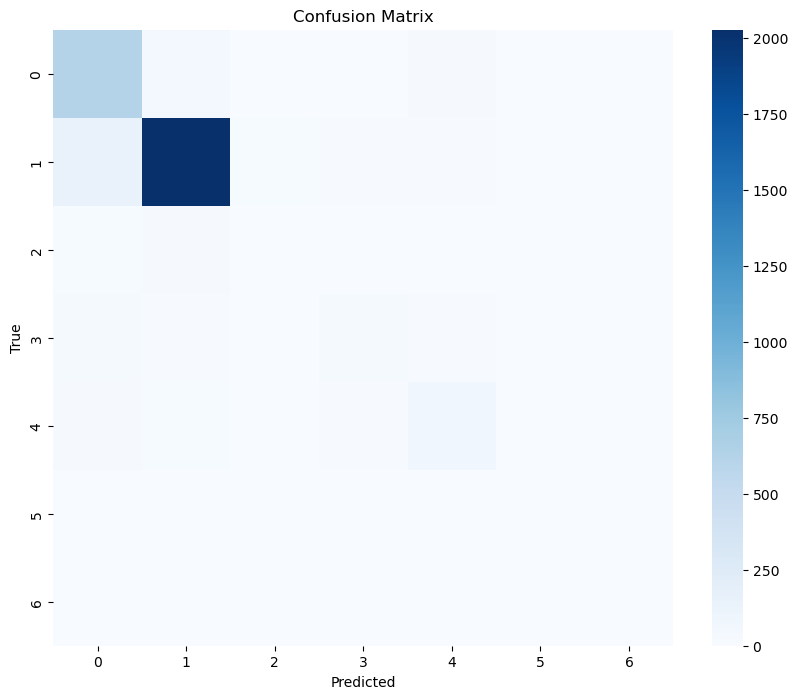

In [31]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

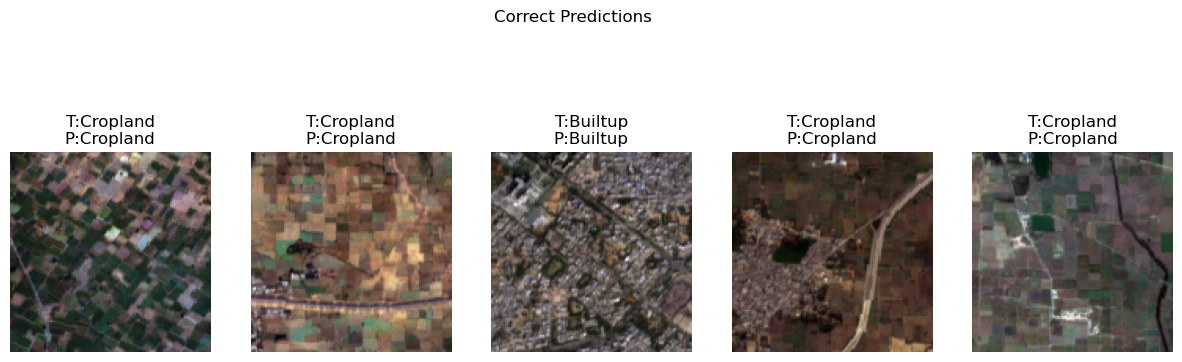

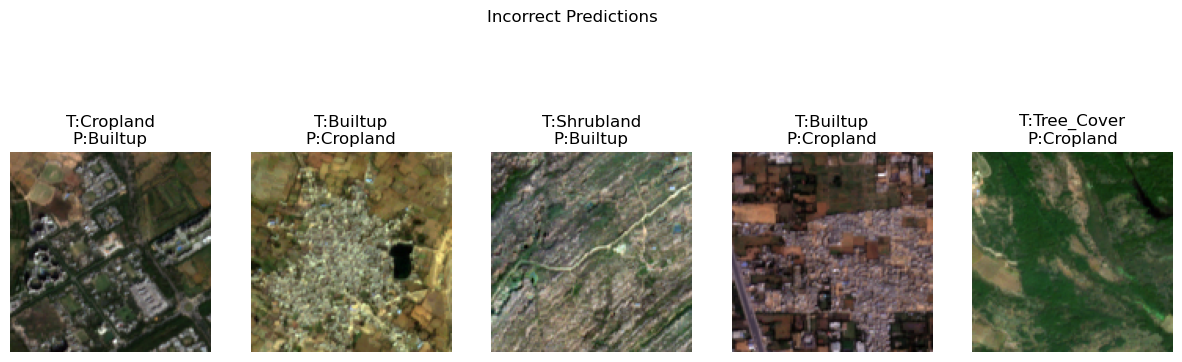

In [32]:
correct_idx = np.where(all_preds == all_labels)[0][:5]
incorrect_idx = np.where(all_preds != all_labels)[0][:5]

def show_examples(indices, title):
    plt.figure(figsize=(15,5))
    for i, idx in enumerate(indices):
        img_path = os.path.join(img_dir, os.path.basename(test_df.iloc[idx]['image']))
        img = Image.open(img_path)

        plt.subplot(1,5,i+1)
        plt.imshow(img)
        true_label = idx_to_class[all_labels[idx]]
        pred_label = idx_to_class[all_preds[idx]]
        plt.title(f"T:{true_label}\nP:{pred_label}")
        plt.axis("off")

    plt.suptitle(title)
    plt.show()

show_examples(correct_idx, "Correct Predictions")
show_examples(incorrect_idx, "Incorrect Predictions")